In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('paper')

# Set up an initial configuration in REBOUND

Let's set up a REBOUND simulation with three Earth-mass planets around a solar-mass star. The inner two planets' orbital periods are at the 3:2 MMR, while the outermost orbital period does not form any simple integer ratios with the inner two. Inclinations and eccentricities are a couple percent, and the inner two particles are initialized at the location where their orbits are spaced furthest apart.

In [2]:
import rebound
def get_sim():
    np.random.seed(1)
    sim = rebound.Simulation()
    sim.add(m=1)
 
    sim.G = 4*np.pi*np.pi
    mass=3e-6
    e=0.01
    inc=0.05
    
    sim.add(m=mass,P=1, e=0.02, pomega=0, theta=np.pi, inc=0.02)
    sim.add(m=mass,P=3/2, e=0.03, pomega=0, theta=np.pi, inc=0.03)
    sim.add(m=mass,P=3.2, e=0, pomega=0, theta=0)
    sim.move_to_com()
    
    sim.dt = sim.particles[1].P / 30.
    sim.integrator='whfast'
    return sim 

Text(0, 0.5, 'y (AU)')

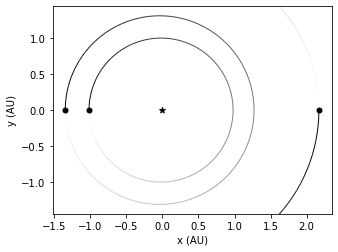

In [3]:
sim=get_sim()
fig, ax = rebound.OrbitPlot(sim)
ax.set_xlabel('x (AU)')
ax.set_ylabel('y (AU)')

# Make a celmech model

Import Poincare variable functions from the celmech package

In [4]:
from celmech import Poincare, PoincareHamiltonian

Initialize model directly from the REBOUND simulation

In [5]:
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)

A 'Poincare' object stores a set of particles with Poincare canonical coordinates (see definitions in the paper). We will switch back to more familiar orbital elements shortly below:

Now construct a Hamiltonian model with the Poincare varaibles:

In [6]:
Hp = PoincareHamiltonian(poincare_variables)

The 'Hamlitonian' object keeps track of a symbolic Hamiltonian. By default, only 𝑁 distinct Keplerian terms are included (with no interactions between the planets).

In [7]:
Hp.H

   2   2   3    2   2   3    2   2   3
  G ⋅M₃ ⋅μ₃    G ⋅M₂ ⋅μ₂    G ⋅M₁ ⋅μ₁ 
- ────────── - ────────── - ──────────
        2            2            2   
    2⋅Λ₃         2⋅Λ₂         2⋅Λ₁    


Now let's add the leading order terms for the 3:2 MMR between the inner two planets

In [8]:
Hp.add_MMR_terms(p=3, q=1, indexIn=1, indexOut=2)
Hp.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                  
───── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\
____       _______________ ⎟                                                  
,0}      ╲╱ \Lambda_{1,0}  ⎠                                                  
──────────────────────────── - ───────────────────────────────────────────────
                                                   

This call has added the two leading-order MMR interaction terms. While this is the Hamiltonian celmech is using under the hood, we can also see the interaction terms in more familiar orbital elements by checking the disturbing function property `df`

In [9]:
Hp.df

<IPython.core.display.Math object>

Just like a REBOUND Simulation, our celmech model can also be integrated with the terms we have added above. Let's run both our celmech and Nbody models and compare the eccentricity evolution of the middle planet:

In [10]:
%%time
Nout = 1000
tmax = 10000
e2, Ne2= np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0, tmax, Nout)
ps = sim.particles
for i, time in enumerate(times):
    Hp.integrate(time)
    sim.integrate(time)
    e2[i] = Hp.particles[2].e
    Ne2[i] = sim.particles[2].e

CPU times: user 4.07 s, sys: 96.3 ms, total: 4.17 s
Wall time: 4.66 s


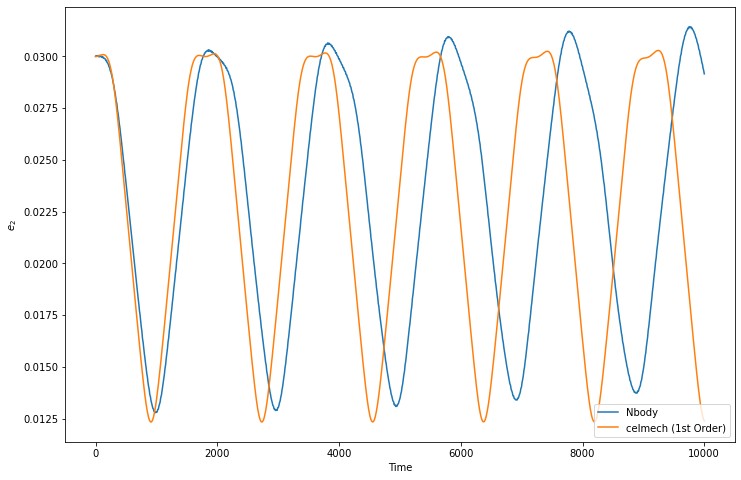

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Ne2, label='Nbody')
ax.plot(times, e2, label='celmech (1st Order)')
ax.set_xlabel('Time')
ax.set_ylabel('$e_2$')
ax.legend(loc='lower right')
fig.savefig('firstorder.pdf', dpi=300, bbox_inches='tight')

# Going to Second Order

We can get closer to the N-body integrations by going to higher order in the eccentricities and inclinations. We can do this easily by passing the `max_order` keyword to `add_MMR_terms`. To go to second order in the inclinations and eccentricities:

In [12]:
max_order = 2
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)

Hp.add_MMR_terms(p=3, q=1, max_order=2, indexIn=1, indexOut=2)
Hp.df

<IPython.core.display.Math object>

We have now included the second order 6:4 terms, which introduce the first inclination-dependent terms. We can also add the secular terms for every pair of planets (which only start appearing at second-order) with

In [13]:
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        print('Adding secular terms for planets {0} and {1}'.format(idx1, idx2))
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)
Hp.df

Adding secular terms for planets 1 and 2
Adding secular terms for planets 1 and 3
Adding secular terms for planets 2 and 3


<IPython.core.display.Math object>

Now we integrate again and compare

In [14]:
e2_2 = np.zeros(Nout)
for i, time in enumerate(times):
    Hp.integrate(time)
    e2_2[i] = Hp.particles[2].e

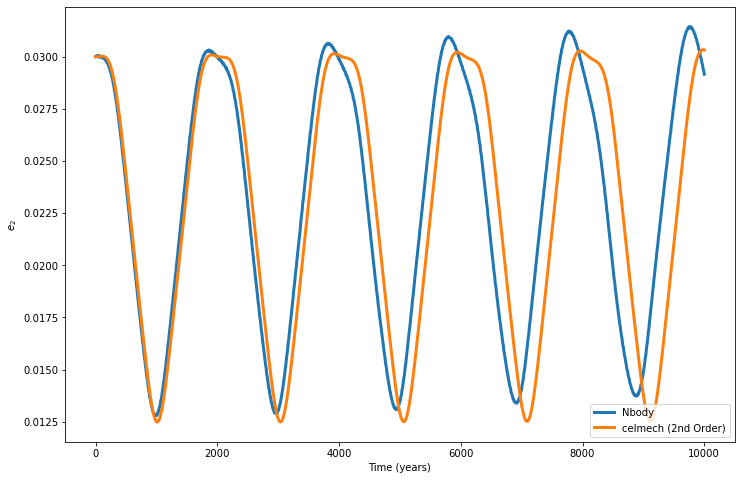

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Ne2, lw=3, label='Nbody')
ax.plot(times, e2_2, lw=3, label='celmech (2nd Order)')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$e_2$')
ax.legend(loc='lower right')

# Osculating vs Mean Variables

Going to second order in the eccentricities and inclinations got us closer to the N-body integrations. One might guess that going to even higher order would keep improving the match, but that is not the case here.

There is a separate issue leading to the discrepancy above with N-body, which is our rather special initial conditions starting at conjunction. If we run a short N-body integration, we see that our initial semimajor axes are not representative of the typical or mean values, but rather are at the tops of the unrepresentative spikes at conjunctions.

Text(0, 0.5, '$a_1$ (AU)')

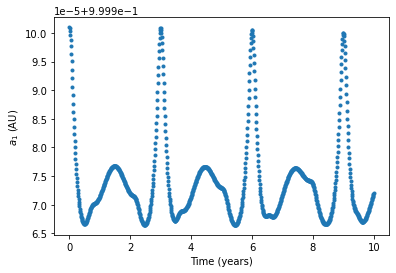

In [16]:
sim = get_sim()
a = np.zeros(Nout)
short_times = np.linspace(0, 10, Nout)
for i, time in enumerate(short_times):
    sim.integrate(time)
    a[i] = sim.particles[1].a
    
fig, ax = plt.subplots()
ax.plot(short_times, a, '.')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$a_1$ (AU)')

One can deal with this issue by going from "osculating" variables in the full problem (including the spikes) to "mean" variables, which average out those short-period effects to yield orbital elements that vary smoothly on long timescales.

The most elegant way to do that is through a near-identity canonical transformation using Lie series (see paper). We can set up this transformation by setting up our Hamiltonian like before

In [17]:
max_order = 2
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_MMR_terms(p=3, q=1, max_order=max_order, indexIn=1, indexOut=2)
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)

and then making a `FirstOrderGeneratingFunction`

In [18]:
from celmech.lie_transformations import FirstOrderGeneratingFunction

chi = FirstOrderGeneratingFunction(poincare_variables)

We now need to add all the fast terms in the disturbing function we want to average over. It turns out the terms leading to the spikes at conjunctions can be summed into a single term, which is zeroth-order in (i.e., does not involve) the eccentricities and inclinations. We can add it through

In [19]:
chi.add_zeroth_order_term()

This is the most important term to add, given our setup at conjunction. We can also add other unmodeled terms in our disturbing function we want to correct for. For example, we would correct for the adjacent strong (first-order) MMRs between the inner two planets (4:3 and 2:1) with

In [20]:
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)

We then transform from osculating to mean variables

In [21]:
%%time
chi.osculating_to_mean()

CPU times: user 3.91 s, sys: 90.2 ms, total: 4 s
Wall time: 4.83 s


We see that now instead starting with the semimajor axis at the top of the spike (at t=0), we initialize the semimajor axes with their mean values, which provide more representative values for the period ratio

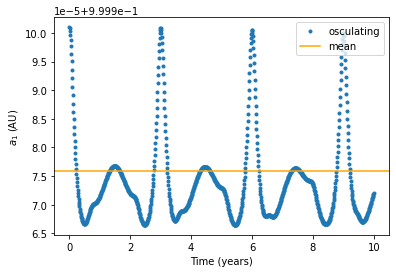

In [22]:
fig, ax = plt.subplots()
ax.plot(short_times, a, '.', label='osculating')
ax.axhline(Hp.particles[1].a, color='orange', label='mean')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$a_1$ (AU)')
ax.legend(loc='upper right')

If we now compare with Nbody, we see that the agreement becomes very good

In [23]:
e2_2_mean = np.zeros(Nout)
for i, time in enumerate(times):
    Hp.integrate(time)
    e2_2_mean[i] = Hp.particles[2].e

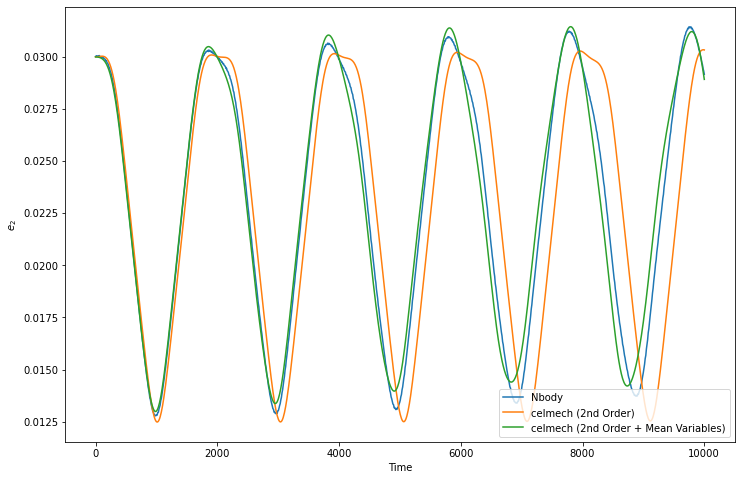

In [24]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Ne2, label='Nbody')
ax.plot(times, e2_2, label='celmech (2nd Order)')
ax.plot(times, e2_2_mean, label='celmech (2nd Order + Mean Variables)')
ax.set_xlabel('Time')
ax.set_ylabel('$e_2$')
ax.legend(loc='lower right')
fig.savefig('secondorder.pdf', dpi=300, bbox_inches='tight')

The agreement for the eccentricities is now excellent. Unfortunately, the inclinations, which vary on a longer timescale (since the leading order terms are second order), are not as accurate. In order to match those closely, we need to go to third order in the eccentricities and inclinations (after moving to mean variables), which is the lowest order including terms that directly couple the inclinations with the rapidly varying eccentricities. Let's therefore compare different-order approximations.

# Going to Higher Order

Let's begin by running a longer $10^5$ year integration (to capture a full inclination cycle of the middle planet) with both N-body and our above second-order model (a first-order model would have flat inclinations since there are no first-order inclination terms).

In [25]:
%%time
sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)

max_order = 2
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_MMR_terms(p=3, q=1, max_order=max_order, indexIn=1, indexOut=2)
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)
chi = FirstOrderGeneratingFunction(poincare_variables)
chi.add_zeroth_order_term()
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)
chi.osculating_to_mean()

CPU times: user 2.8 s, sys: 42.1 ms, total: 2.84 s
Wall time: 2.94 s


In [26]:
%%time
tmax= 100000
i2_2, Ni2= np.zeros(Nout), np.zeros(Nout)
itimes = np.linspace(0, tmax, Nout)
ps = sim.particles
for i, time in enumerate(itimes):
    Hp.integrate(time)
    sim.integrate(time)
    i2_2[i] = Hp.particles[2].inc
    Ni2[i] = sim.particles[2].inc

CPU times: user 22 s, sys: 272 ms, total: 22.3 s
Wall time: 24 s


Notice that as we go to third order, the number of terms gets very large and integration times become much longer (1 min 15s on a macbook pro)

In [ ]:
%%time
max_order = 3

sim=get_sim()
poincare_variables = Poincare.from_Simulation(sim)
Hp = PoincareHamiltonian(poincare_variables)
Hp.add_MMR_terms(p=3, q=1, max_order=max_order, indexIn=1, indexOut=2)
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_secular_terms(max_order=max_order, indexIn=idx1, indexOut=idx2)
chi = FirstOrderGeneratingFunction(poincare_variables)
chi.add_zeroth_order_term()
chi.add_MMR_terms(p=2,q=1,l_max=1, indexIn=1, indexOut=2)
chi.add_MMR_terms(p=4,q=1,l_max=1, indexIn=1, indexOut=2)
chi.osculating_to_mean()

i2_3 = np.zeros(Nout)
for i, time in enumerate(itimes):
    Hp.integrate(time)
    i2_3[i] = Hp.particles[2].inc

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(times, Ni2, lw=3, label='Nbody')
ax.plot(times, i2_2, lw=3, label='celmech (2nd Order + Mean Variables)')
ax.plot(times, i2_3, lw=3, label='celmech (3rd Order + Mean Variables)')
ax.set_xlabel('Time (years)')
ax.set_ylabel('$i_2$ (rad)')
ax.legend(loc='upper right')
fig.savefig('thirdorder.pdf', dpi=300, bbox_inches='tight')

# When going to higher order in the eccentricities and inclinations doesn't help

The reason why we could continue getting better agreement by going to higher order in the eccentricities and inclinations was the low masses of our planets. The ability we exploited above to go from osculating to mean variables through a canonical transformation is too good to be true rigorously. It is only correct to leading order in the planet-star mass ratio, and this correction introduces additional terms in the disturbing function at second order in the masses. 

Adding smaller and smaller terms in the eccentricities and inclinations only helps until they reach the size of the second-order mass terms. For higher mass planets, these second order mass terms can be important (see paper and references therein).

To finish, we can check how many terms are in our disturbing function at third order!

In [ ]:
Hp.df

# Note for higher masses

A subtle correction that does not matter here but is important for higher-mass planets in MMRs is secular corrections planets' mean motions. In addition to the various oscillating terms, there is a secular correction to the mean motion of each planet, which comes from the orbit-averaged effect of each of the other planets. In the disturbing function, these corrections to $\dot{\lambda_i} = \partial{H}/\partial{\Lambda_i}$ come from the fact that the disturbing function coefficients depend on the planets' semi-major axes. These corrections are most easily calculated by expanding disturbing function coefficients in $\Lambda_i$ around their reference values $\Lambda_{i,0}$. It is generally sufficient to include only the linear terms in this expansion, $\propto (\Lambda_i - \Lambda_{i,0})$ at the lowest order (i.e., 0th) in the planets' eccentricities and inclinations. These terms can be included by adding the specific cosine term with `k_vec=[0,0,0,0,0,0]` (i.e., the constant term) while setting `l_max=1` (first-order expansion in the $\Lambda_i$ around the reference values).
We do this below, iterating over all pairs like for the secular terms above:

In [ ]:
for idx1 in range(1,sim.N):
    for idx2 in range(idx1+1,sim.N):# get all combinations of planets
        Hp.add_cosine_term(k_vec=[0,0,0,0,0,0],max_order=0,l_max=1, indexIn=idx1, indexOut=idx2)